In [1]:
import os
import numpy

#%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('error', category=UnicodeWarning)

import time
import gzip

from IPython.display import clear_output

# K-means

In [2]:
def my_distance_matrix(x, y):
    x = x.astype(numpy.float64)
    y = y.astype(numpy.float64)
    assert len(x.shape) == len(y.shape) == 2
    assert x.shape[1] == y.shape[1]
    
    # (a - b) ** 2 = (a, a) - 2 (a, b) + (b, b)
    ans =  numpy.repeat((x*x).sum(axis=1), y.shape[0]).reshape(x.shape[0], -1)
    ans += - 2 * numpy.einsum('ij,kj->ik', x, y) 
    ans += numpy.repeat((y*y).sum(axis=1), x.shape[0]).reshape(y.shape[0], -1).T
    return ans ** .5

class k_means:
    def __init__(self, k, init=None):
        if init is None:
            init = self._random_choice
        self.init = init
        self.nclusters = k
        self.centers = None
        self.debug = False

    @staticmethod
    def _random_choice(n, x):
        return (numpy.random.default_rng(seed=numpy.random.randint(0, 2**32))
                .choice(x, size=n, replace=False))

    def train(self, x, debug=False):
        self.centers = self.init(self.nclusters, x)
        prev = None
        while (prev != self.centers).all():
            cl = self.clusters(x)
            # new centers are means of each group
            new = numpy.array([
                    x.mean(axis=0) if len(x) else self.centers[i]
                    for i, x in enumerate(cl)])
            self.centers, prev = new, self.centers
        return self

    def __call__(self, x):
        assert self.centers is not None
        return my_distance_matrix(x, self.centers).argmin(axis=1)
    
    def clusters(self, x):
        assert len(x.shape) == 2
        cl = self(x)
        return [x[cl == i] for i in range(self.centers.shape[0])]

### testing

In [3]:
def init_farthest(n, x):
    y = (numpy.random.default_rng(seed=numpy.random.randint(0, 2**32))
            .choice(x, size=1))
    for i in range(n-1):
        y = numpy.concatenate([
                (x[my_distance_matrix(x, y, ).min(axis=1).argmax()]
                        .reshape(1, -1)),
                y])
    return y

def init_plusplus(n, x):
    y = (numpy.random.default_rng(seed=numpy.random.randint(0, 2**32))
            .choice(x, size=1))
    for i in range(n-1):
        probs = my_distance_matrix(x, y).min(axis=1) ** 2
        probs /= probs.sum()
        cs = numpy.cumsum(probs)
        r = numpy.random.rand()
        y = numpy.concatenate([
            x[(cs < r) & (probs != 0)][0:1],
            y])
    return y

In [4]:
def strange_clustering_loss(clusters):
    avg = 0
    for c in clusters:
        n = len(c)
        avg += my_distance_matrix(c, c).mean() / n
    cc = numpy.concatenate(clusters)
    n = len(cc)
    return avg

In [5]:
def gen1(N=100):
    st = numpy.array([1.5 + abs(numpy.random.randn(N)) * 3,
            numpy.random.randn(N)-3])
    st[1] /= st[0]
    x = numpy.concatenate([numpy.random.randn(N, 2)/3,
            2 + numpy.random.randn(N, 2)/3,
            st.T])
    return x

def gen2(N=100, std=1/3, r=1):
    alp = numpy.random.rand(N) * 2 * numpy.pi
    r = r + numpy.random.randn(N) * std
    x = numpy.array([r * numpy.cos(alp), r * numpy.sin(alp)]).T
    return x

def gen3(N=1000, dims=100, c=10, d=10):
    n = N % c
    N //= c
    x = numpy.concatenate([numpy.random.randn(N + n * (not i), 1) * d
            + numpy.random.randn(N + n * (not i), dims) for i in range(c)])
    return x

1259061126
0.08549528441585014


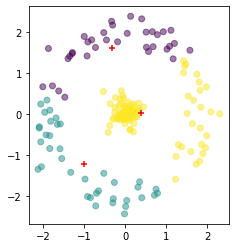

0.06998552994132069


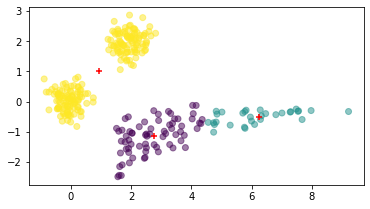

In [6]:
if 1:
    s = numpy.random.randint(0, 2**32-1)
    print(s)
    numpy.random.seed(s)
else:
    numpy.random.seed(3368459579)

kcl = k_means(3, init_farthest)
xx = [numpy.concatenate([gen2(100, 1/5, 2), gen2(100, 1/4, 0)]),
      gen1(100)]
for x in xx:
    kcl.train(x)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(x[:, 0], x[:, 1], c=kcl(x), alpha=0.5)
    plt.scatter(kcl.centers[:, 0], kcl.centers[:, 1], c='red', marker='+')
    print(strange_clustering_loss(kcl.clusters(x)))
    plt.show()

In [7]:
for name, kcl in [('k-means++', k_means(3, init_plusplus)),
        ('k-means', k_means(3)),
        ('farthest', k_means(3, init_farthest))]:
    print(name)
    for i, x in enumerate(xx):
        gg = x
        kcl.train(gg)
        print(sum([(kcl.train(gg), strange_clustering_loss(kcl.clusters(gg)))[1]
                for i in range(1000)]))
    print()

k-means++
83.96062634457873
38.6459037797294

k-means
85.95696043010051
45.23709138866331

farthest
85.36720247340621
63.768504369752925



# Time

It is almost linear

### 2D

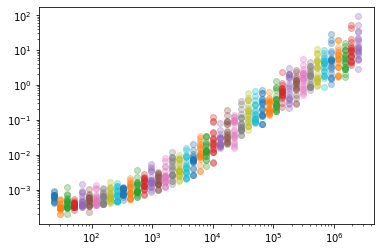

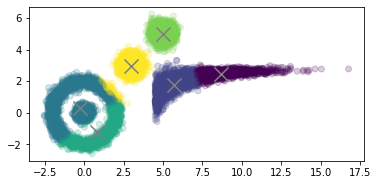

CPU times: user 20min 6s, sys: 2min 45s, total: 22min 52s
Wall time: 22min 53s


In [8]:
%%time

t = []
sz = 3 * numpy.floor(1.3 ** numpy.arange(8, 53)).astype(numpy.int64)
lt = 0
removed = None

for N in sz:
    training = False
    try:
        assert N%3 == 0
        xx = numpy.concatenate([gen2(N//3, 1/5, 2), gen2(N//3, 1/4, 0), 3 + gen1(N//3)])
        kcl = k_means(6)  # creating model
        t.append([])
        for i in range(20):
            training = True
            t[-1].append(time.time())
            kcl.train(xx)  # training
            t[-1][-1] = time.time() - t[-1][-1]
            training = False
        if time.time() - lt > 1:
            plt.xscale('log')
            plt.yscale('log')
            for s, tt in zip(sz[:len(t)], t):
                plt.scatter(s * numpy.ones(len(tt)), tt, alpha=0.3)
            clear_output(wait=True)
            plt.show()
            lt = time.time()
    except KeyboardInterrupt:
        if training:
            removed = t[-1].pop()
        break
        
        
clear_output(wait=True)
if removed is not None:
    print('removed', removed)
plt.xscale('log')
plt.yscale('log')
for s, tt in zip(sz[:len(t)], t):
    plt.scatter(s * numpy.ones(len(tt)), tt, alpha=0.3)
plt.show()
N = 10000
xx = numpy.concatenate([gen2(N//3, 1/5, 2), gen2(N//3, 1/4, 0), 3 + gen1(N//3)])
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(xx[:, 0], xx[:, 1], c=kcl(xx), alpha=0.2)
plt.scatter(kcl.centers[:, 0], kcl.centers[:, 1], 200, c='gray', marker='x')
plt.show()

### 100D

removed 1605216645.1066701


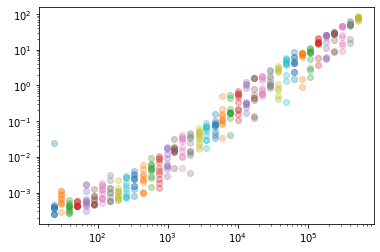

CPU times: user 33min 59s, sys: 6min 22s, total: 40min 21s
Wall time: 40min 24s


In [9]:
%%time

t = []
sz = 3 * numpy.floor(1.3 ** numpy.arange(8, 53)).astype(numpy.int64)
lt = 0
removed = None

for N in sz:
    training = False
    try:
        assert N%3 == 0
        xx = gen3(N, 100)
        kcl = k_means(6)  # creating model
        t.append([])
        for i in range(10):
            training = True
            t[-1].append(time.time())
            kcl.train(xx)  # training
            t[-1][-1] = time.time() - t[-1][-1]
            training = False
        if time.time() - lt > 1:
            plt.xscale('log')
            plt.yscale('log')
            for s, tt in zip(sz[:len(t)], t):
                plt.scatter(s * numpy.ones(len(tt)), tt, alpha=0.3)
            clear_output(wait=True)
            plt.show()
            lt = time.time()
    except KeyboardInterrupt:
        if training:
            removed = t[-1].pop()
        break
        
        
clear_output(wait=True)
if removed is not None:
    print('removed', removed)
plt.xscale('log')
plt.yscale('log')
for s, tt in zip(sz[:len(t)], t):
    plt.scatter(s * numpy.ones(len(tt)), tt, alpha=0.3)
plt.show()

# MNIST experiments

In [6]:
def load_MNIST_file(url, label=False, directory='.'):

    if directory[-1] != '/':
        directory += '/'
    fname = directory + url[url.rfind('/') + 1 :]
    if not os.path.exists(fname):
        os.system('curl {0} > {1}'.format(url, fname))
    file = gzip.open(fname, 'r')
    if not label:
        # see FILE FORMATS FOR THE MNIST DATABASE on yann.lecun.com/exdb/mnist
        file.read(16)
        image_size = 28
    else:
        # see FILE FORMATS FOR THE MNIST DATABASE on yann.lecun.com/exdb/mnist
        file.read(8)
        image_size = 1
    buf = file.read()
    data = numpy.frombuffer(buf, dtype=numpy.uint8)
    if not label:
        data = data.reshape(-1, image_size, image_size)
    file.close()
    return data

def get_MNIST(directory):
    train_image_url =  'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
    train_labels_url = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
    test_image_url =   'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
    test_labels_url =  'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
    return (load_MNIST_file(train_image_url, False, directory),
            load_MNIST_file(train_labels_url, True, directory),
            load_MNIST_file(test_image_url, False, directory),
            load_MNIST_file(test_labels_url, True, directory))

In [7]:
directory_for_MNIST = 'MNIST-dataset'
if not os.path.exists(directory_for_MNIST):
    os.mkdir(directory_for_MNIST)
x_train, y_train, x_test, y_test = get_MNIST(directory_for_MNIST)
nclasses = 10

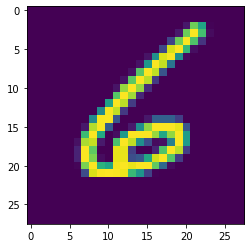

6


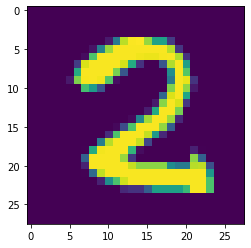

2


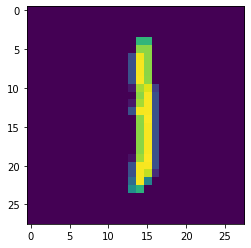

1


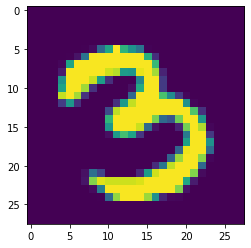

3


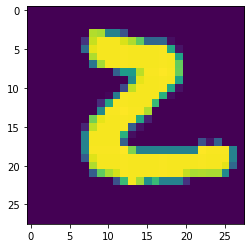

2


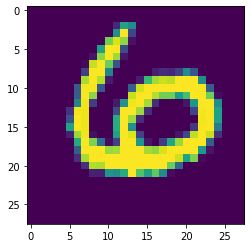

6


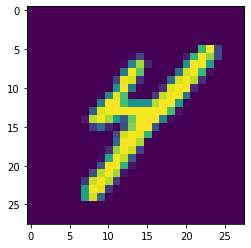

4


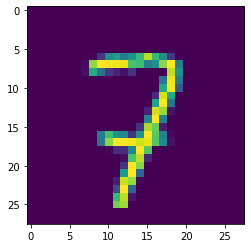

7


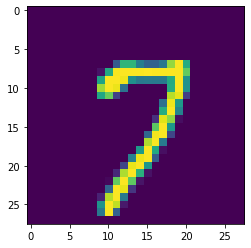

7


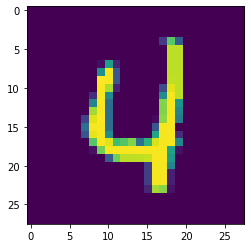

4


In [8]:
for i in numpy.random.randint(0, x_train.shape[0], size=10):
    plt.imshow(x_train[i])
    plt.show()
    print(y_train[i])

In [14]:
def flatten(x):
    return x.reshape(x.shape[0], -1)

In [15]:
x_train = flatten(x_train)

In [15]:
%%time
nclusters = 3000
model = k_means(nclusters)
model.train(x_train)

CPU times: user 1min 51s, sys: 2.58 s, total: 1min 54s
Wall time: 2min


In [16]:
def train_classifier(x_train, y_train, nclusters, nclasses):
    model = k_means(nclusters)
    model.train(x_train)
    y = model(x_train)
    class_p = []
    for i in range(nclusters):
        y_i = y_train[y == i]
        class_p.append(numpy.array([(y_i == j).mean() for j in range(nclasses)]))
    class_p = numpy.array(class_p)
    class_argmax = class_p.argmax(axis=1)

    return model, lambda x: class_argmax[model(x)]

In [46]:
%%time
model, classifier = train_classifier(x_train, y_train, 4000, 10)

CPU times: user 4min 23s, sys: 6.58 s, total: 4min 30s
Wall time: 6min 10s


In [47]:
%%time
print('train acc: ', (classifier(x_train) == y_train).mean())

train acc:  0.9489333333333333
CPU times: user 1min 53s, sys: 884 ms, total: 1min 53s
Wall time: 1min 54s


In [48]:
%%time
print('test acc: ', (classifier(flatten(x_test)) == y_test).mean())

test acc:  0.9501
CPU times: user 18.7 s, sys: 184 ms, total: 18.9 s
Wall time: 19.8 s
